**Data Mining Group 4 Jupyter Notebook**

By: Assaf Bohen, Adrian Nica, TJ Jablonski

In [1]:
import requests
import zipfile
import io
import pandas as pd
from urllib.parse import urlparse
import os

def download_and_extract_csv(zip_url):
    """
    Downloads a ZIP file from `zip_url`, extracts the first .csv file found,
    and returns it as a Pandas DataFrame.
    """
    #determines if zip is found
    response = requests.get(zip_url)
    if response.status_code == 200:
        zip_content = io.BytesIO(response.content)
        
        #extract csv files
        with zipfile.ZipFile(zip_content, 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                if file_name.endswith('.csv'):
                    with zip_ref.open(file_name) as csv_file:
                        df = pd.read_csv(csv_file)

                        #print success
                        parsed_url = urlparse(zip_url)
                        print(f'Successfully extracted {file_name} from {os.path.basename(parsed_url.path)}')
                        return df

        #no csv files found
        return None
    else:
        print(f"Failed to retrieve ZIP from {zip_url}")
        return None

In [2]:
#urls to zip files
csv_url_2024 = "https://cdn.sanity.io/files/jo7n4k8s/production/262f04c41d99fea692e0125c342e446782233fe4.zip/stack-overflow-developer-survey-2024.zip"
csv_url_2023 = "https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/stack-overflow-developer-survey-2023.zip"
csv_url_2022 = "https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip"

#download csv files
odf_2024 = download_and_extract_csv(csv_url_2024)
odf_2023 = download_and_extract_csv(csv_url_2023)
odf_2022 = download_and_extract_csv(csv_url_2022)

Successfully extracted survey_results_public.csv from stack-overflow-developer-survey-2024.zip
Successfully extracted survey_results_public.csv from stack-overflow-developer-survey-2023.zip
Successfully extracted survey_results_public.csv from stack-overflow-developer-survey-2022.zip


In [3]:
#converts column names to uppercase and removes spacing
odf_2024.columns = odf_2024.columns.str.upper().str.replace(" ", "")
odf_2023.columns = odf_2023.columns.str.upper().str.replace(" ", "")
odf_2022.columns = odf_2022.columns.str.upper().str.replace(" ", "")

#prints all rows
with pd.option_context('display.max_columns', None,
                       'display.max_rows', None,
                       'display.width', 6000):
    print(odf_2024.head())

   RESPONSEID                      MAINBRANCH                 AGE           EMPLOYMENT REMOTEWORK   CHECK                                   CODINGACTIVITIES                                            EDLEVEL                                          LEARNCODE                                    LEARNCODEONLINE                                            TECHDOC YEARSCODE YEARSCODEPRO                DEVTYPE ORGSIZE PURCHASEINFLUENCE BUYNEWTOOL BUILDVSBUY TECHENDORSE                                            COUNTRY CURRENCY  COMPTOTAL                             LANGUAGEHAVEWORKEDWITH                             LANGUAGEWANTTOWORKWITH                                    LANGUAGEADMIRED           DATABASEHAVEWORKEDWITH      DATABASEWANTTOWORKWITH             DATABASEADMIRED                    PLATFORMHAVEWORKEDWITH                    PLATFORMWANTTOWORKWITH                           PLATFORMADMIRED                  WEBFRAMEHAVEWORKEDWITH            WEBFRAMEWANTTOWORKWITH               WEBFRA

In [4]:
#drop all cols from odf_2024 that didn't select Apples (only survey to check for bots)
print(f'odf_2024 rows before dropping bots: {odf_2024.shape[0]}')
odf_2024 = odf_2024[odf_2024['CHECK'] == 'Apples']
print(f'odf_2024 rows after dropping bots: {odf_2024.shape[0]}\n')

#finds common column names across all dfs
common_cols = set(odf_2024.columns).intersection(odf_2023.columns).intersection(odf_2022.columns)

#creates copies of dfs
df_2024 = odf_2024[list(common_cols)].copy()
df_2023 = odf_2023[list(common_cols)].copy()
df_2022 = odf_2022[list(common_cols)].copy()

#adds a year column to all dfs
df_2024["year"] = 2024
df_2023["year"] = 2023
df_2022["year"] = 2022

#combined the common columns of the dfs
combined_df = pd.concat([df_2024, df_2023, df_2022], ignore_index=True)

#prints shape and all rows
print(f"Combined DataFrame shape: {combined_df.shape}")
with pd.option_context('display.max_columns', None,
                       'display.max_rows', None,
                       'display.width', 6000):
    print(combined_df.head())

odf_2024 rows before dropping bots: 65437
odf_2024 rows after dropping bots: 65437

Combined DataFrame shape: (227889, 63)
   COMPTOTAL  RESPONSEID  WORKEXP KNOWLEDGE_7 KNOWLEDGE_3 SOACCOUNT           SURVEYLENGTH TIMESEARCHING                                   CODINGACTIVITIES             SOVISITFREQ           SOCOMM REMOTEWORK                      TOOLSTECHHAVEWORKEDWITH                 AGE ORGSIZE                                            EDLEVEL                                    LEARNCODEONLINE           DATABASEHAVEWORKEDWITH         NEWCOLLABTOOLSWANTTOWORKWITH                 OFFICESTACKSYNCHAVEWORKEDWITH                    PLATFORMWANTTOWORKWITH            WEBFRAMEWANTTOWORKWITH OFFICESTACKSYNCWANTTOWORKWITH                  ICORPM                             LANGUAGEHAVEWORKEDWITH                                         NEWSOSITES CURRENCY                      TOOLSTECHWANTTOWORKWITH      DATABASEWANTTOWORKWITH KNOWLEDGE_2 FREQUENCY_2 KNOWLEDGE_4 PURCHASEINFLUENCE           

In [5]:
combined_df.shape

(227889, 63)

-------------------------------------------------------------------------------------                       
.

**Compensation Data Exploration**

.

-------------------------------------------------------------------------------------

In [6]:
#show changes
print(f'Number of columns in compensation_df: {combined_df.shape[1]}')

#columns to include in compensatiion_df
compensation_include_columns = [
    'CONVERTEDCOMPYEARLY',
    'COUNTRY',
    'DEVTYPE',
    'EDLEVEL',
    'YEARSCODE',
    'YEARSCODEPRO',
    'ORGSIZE'
]

#creates jobsat_df
compensation_df = combined_df[compensation_include_columns]

#show changes
print(f'Number of columns in compensation_df: {compensation_df.shape[1]}')
compensation_df.head(3)

Number of columns in compensation_df: 63
Number of columns in compensation_df: 7


,CONVERTEDCOMPYEARLY,COUNTRY,DEVTYPE,EDLEVEL,YEARSCODE,YEARSCODEPRO,ORGSIZE
0,NaN,United States of America,NaN,Primary/elementary school,NaN,NaN,NaN
1,NaN,United Kingdom of Great Britain and Northern I...,"Developer, full-stack","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,17,NaN
2,NaN,United Kingdom of Great Britain and Northern I...,Developer Experience,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",37,27,NaN


**Cleaning**

In [7]:
#drop all NaN values in CONVERTEDCOMPYEARLY column
print(f'Rows before dropping NaN CCY values: {compensation_df.shape[0]}')
compensation_df = compensation_df.dropna(subset=['CONVERTEDCOMPYEARLY'])
print(f'Rows after dropping NaN CCY values: {compensation_df.shape[0]}\n')

#drop all remaining NaN values
print(f'Rows before dropping all remaining NaN values: {compensation_df.shape[0]}')
compensation_df = compensation_df.dropna()
print(f'Rows after dropping all remaining NaN values: {compensation_df.shape[0]}\n')

#ensure no more NaN
if sum(compensation_df.isna().sum()) == 0:
    print('All NaN values successfully removed\n')
else:
    print('Dataset still contains NaN values\n')

#drop countries that appear less than 10 times
country_counts = compensation_df['COUNTRY'].value_counts()
rare_countries = country_counts[country_counts > 10].index
print(f"Rows before dropping countries that don't appear at least 10 times: {compensation_df.shape[0]}")
compensation_df = compensation_df[compensation_df['COUNTRY'].isin(rare_countries)]
print(f"Rows after dropping countries that don't appear at least 10 times: {compensation_df.shape[0]}")

#drop outliers based on 1.5*IQR
print(f"Rows before dropping compensation outliers: {compensation_df.shape[0]}")
Q1 = compensation_df['CONVERTEDCOMPYEARLY'].quantile(0.25)
Q3 = compensation_df['CONVERTEDCOMPYEARLY'].quantile(0.75)
IQR = Q3 - Q1
compensation_df = compensation_df[
    (compensation_df['CONVERTEDCOMPYEARLY'] >= Q1 - 1.5 * IQR) &
    (compensation_df['CONVERTEDCOMPYEARLY'] <= Q3 + 1.5 * IQR)
]
print(f"Rows after dropping compensation outliers: {compensation_df.shape[0]}")

#reset index
compensation_df = compensation_df.reset_index(drop=True)

Rows before dropping NaN CCY values: 227889
Rows after dropping NaN CCY values: 109525

Rows before dropping all remaining NaN values: 109525
Rows after dropping all remaining NaN values: 108753

All NaN values successfully removed

Rows before dropping countries that don't appear at least 10 times: 108753
Rows after dropping countries that don't appear at least 10 times: 108562
Rows before dropping compensation outliers: 108562
Rows after dropping compensation outliers: 102856


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

#manually ordinal encode
orgsize_order = {
    'Just me - I am a freelancer, sole proprietor, etc.' : 1,
    '2 to 9 employees' : 2,
    '10 to 19 employees' : 3,
    '20 to 99 employees' : 4,
    '100 to 499 employees' : 5,
    '500 to 999 employees' : 6,
    '1,000 to 4,999 employees' : 7,
    '5,000 to 9,999 employees' : 8,
    '10,000 or more employees' : 9,
    "I don’t know" : -1
}
compensation_df['ORGSIZE'] = compensation_df['ORGSIZE'].map(orgsize_order)

#hot encode COUNTRY and add to compensation_df
country_dummies = pd.get_dummies(compensation_df['COUNTRY'], prefix='COUNTRY').astype(int)
compensation_df = pd.concat([compensation_df.drop(columns=['COUNTRY']), country_dummies], axis=1)

#hot encode EDLEVEL and add to compensation_df
edlevel_dummies = pd.get_dummies(compensation_df['EDLEVEL'], prefix='EDLEVEL').astype(int)
compensation_df = pd.concat([compensation_df.drop(columns=['EDLEVEL']), edlevel_dummies], axis=1)

#multilabel encode DEVTYPE
compensation_df['DEVTYPE'] = compensation_df['DEVTYPE'].str.split(';').apply(lambda x: [i.strip() for i in x] if isinstance(x, list) else [])
mlb = MultiLabelBinarizer()
devtype_encoded = mlb.fit_transform(compensation_df['DEVTYPE'])
devtype_df = pd.DataFrame(devtype_encoded, columns=mlb.classes_, index=compensation_df.index)
compensation_df = pd.concat([compensation_df.drop(columns=['DEVTYPE']), devtype_df], axis=1)

#convert YEARSCODE to int
compensation_df['YEARSCODE'] = compensation_df['YEARSCODE'].replace({
    'More than 50 years': '50',
    'Less than 1 year': '1'
})
compensation_df['YEARSCODE'] = compensation_df['YEARSCODE'].astype(int)

#convert YEARSCODEPRO to int
compensation_df['YEARSCODEPRO'] = compensation_df['YEARSCODEPRO'].replace({
    'More than 50 years': '50',
    'Less than 1 year': '1'
})
compensation_df['YEARSCODEPRO'] = compensation_df['YEARSCODEPRO'].astype(int)

#rename columns and ensures all numeric
numeric = True
compensation_df = compensation_df.rename(columns={'CONVERTEDCOMPYEARLY': 'COMPENSATION'})
for col in compensation_df.columns:
    if compensation_df[col].dtype not in [int, float, 'int64', 'float64']:
        numeric = False
    if col[:8] == 'COUNTRY_':
        compensation_df = compensation_df.rename(columns={col: col[8:]}) 
    if col[:8] == 'EDLEVEL_':
        compensation_df = compensation_df.rename(columns={col: col[8:]})

if(numeric):
    print('All columns are numerical\n')
else:
    print('One or more columns are non-numerical\n')

#show new columns
pd.set_option('display.max_columns', None)
print(compensation_df.shape)
compensation_df.head()



All columns are numerical

(102856, 183)


,COMPENSATION,YEARSCODE,YEARSCODEPRO,ORGSIZE,Afghanistan,Albania,Algeria,Andorra,Argentina,Armenia,Australia,Austria,Azerbaijan,Bangladesh,Belarus,Belgium,Benin,Bolivia,Bosnia and Herzegovina,Brazil,Bulgaria,Cambodia,Cameroon,Canada,Chile,China,Colombia,Costa Rica,Croatia,Cuba,Cyprus,Czech Republic,Côte d'Ivoire,Denmark,Dominican Republic,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Finland,France,Georgia,Germany,Ghana,Greece,Guatemala,Honduras,Hong Kong (S.A.R.),Hungary,Iceland,India,Indonesia,"Iran, Islamic Republic of...",Iraq,Ireland,Isle of Man,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kosovo,Kuwait,Kyrgyzstan,Latvia,Lebanon,Lithuania,Luxembourg,Madagascar,Malaysia,Maldives,Malta,Mauritius,Mexico,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Nepal,Netherlands,New Zealand,Nicaragua,Nigeria,Nomadic,Norway,Pakistan,Palestine,Panama,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Republic of Korea,Republic of Moldova,Republic of North Macedonia,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Singapore,Slovakia,Slovenia,South Africa,South Korea,Spain,Sri Lanka,Sudan,Sweden,Switzerland,Syrian Arab Republic,Taiwan,Thailand,The former Yugoslav Republic of Macedonia,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,Uganda,Ukraine,United Arab Emirates,United Kingdom of Great Britain and Northern Ireland,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,"Venezuela, Bolivarian Republic of...",Viet Nam,Yemen,Zambia,Zimbabwe,"Associate degree (A.A., A.S., etc.)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Other doctoral degree (Ph.D., Ed.D., etc.)",Primary/elementary school,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)","Professional degree (JD, MD, etc.)","Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",Some college/university study without earning a degree,Something else,Academic researcher,Blockchain,Cloud infrastructure engineer,Data engineer,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,Developer Advocate,Developer Experience,"Developer, AI","Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices","Developer, front-end","Developer, full-stack","Developer, game or graphics","Developer, mobile",Educator,"Engineer, data","Engineer, site reliability",Engineering manager,Hardware Engineer,Marketing or sales professional,Other (please specify):,Product manager,Project manager,Research & Development role,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator
0,7322.0,3,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,30074.0,12,6,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,91295.0,15,6,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,53703.0,27,17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

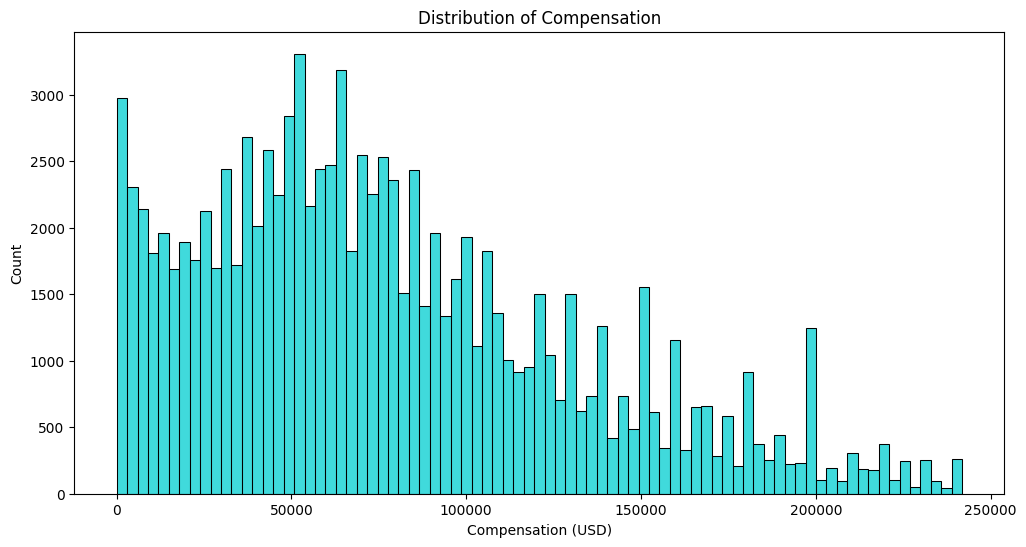

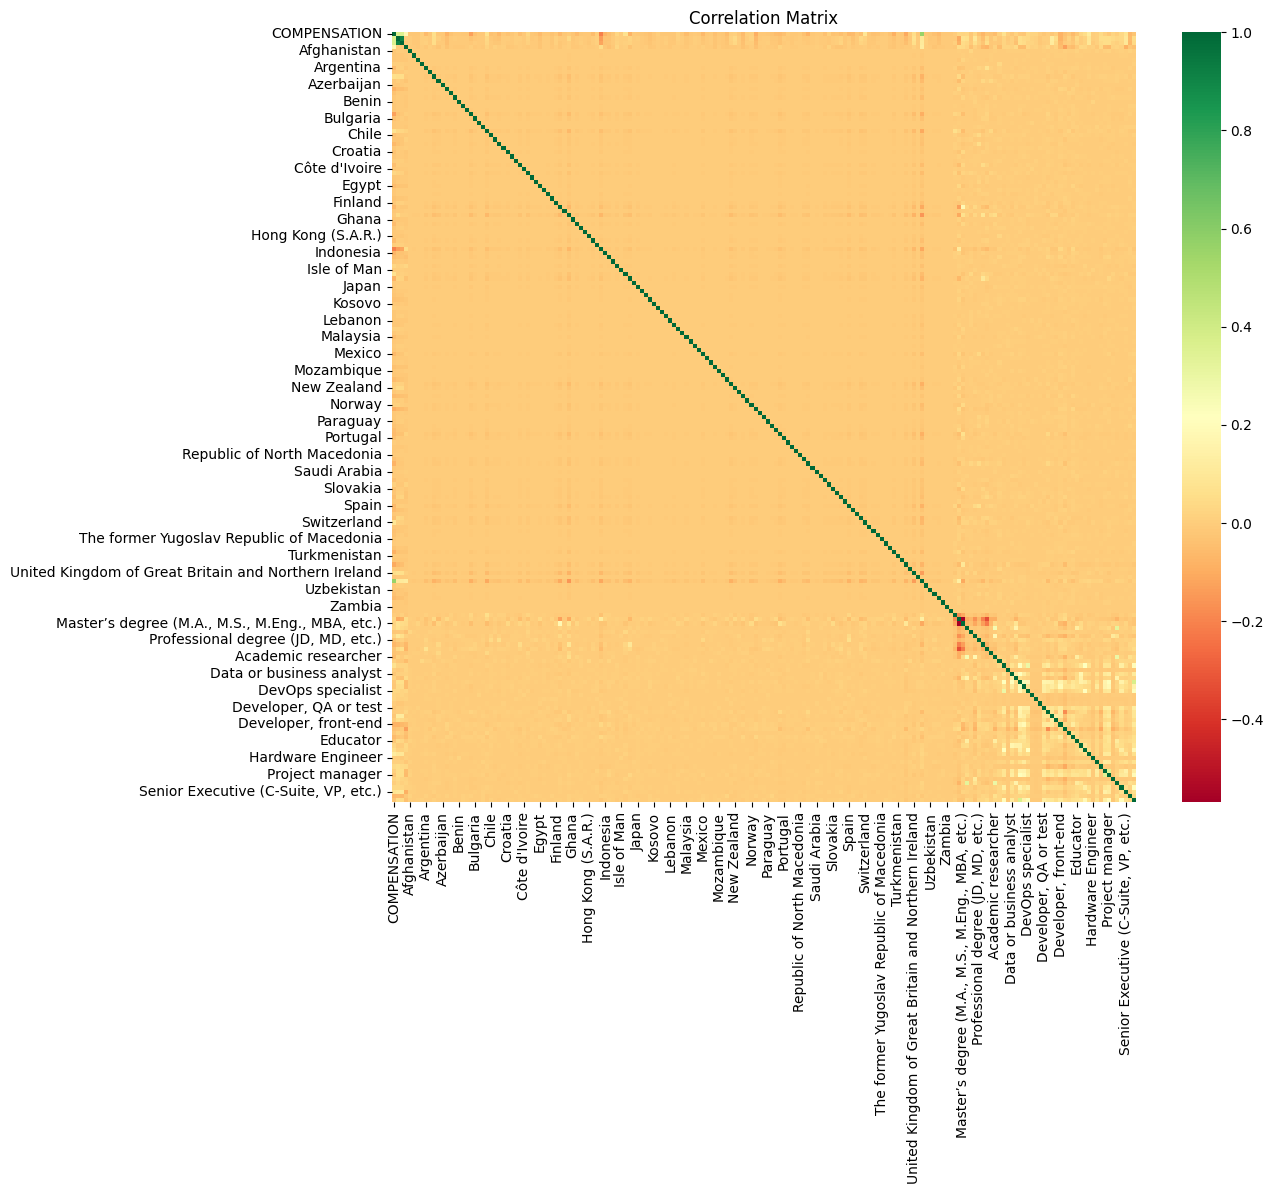

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot w/out outliers
plt.figure(figsize=(12, 6))
sns.histplot(x=compensation_df['COMPENSATION'], color='darkturquoise')
plt.title('Distribution of Compensation')
plt.xlabel('Compensation (USD)')
plt.ylabel('Count')

#plot corr matrix
plt.figure(figsize=(12, 10))
sns.heatmap(compensation_df.corr(), cmap='RdYlGn')
plt.title('Correlation Matrix')
plt.show()

In [10]:
#correlation matrix
compensation_corr = compensation_df.corr()['COMPENSATION'].abs().sort_values(ascending=False)
compensation_corr.head(10)

COMPENSATION                1.000000
United States of America    0.563148
YEARSCODEPRO                0.362495
YEARSCODE                   0.359295
India                       0.213052
ORGSIZE                     0.176205
Brazil                      0.131729
Engineering manager         0.123332
Ukraine                     0.109042
Pakistan                    0.096861
Name: COMPENSATION, dtype: float64

In [11]:
compensation_df.dtypes

COMPENSATION                            float64
YEARSCODE                                 int64
YEARSCODEPRO                              int64
ORGSIZE                                   int64
Afghanistan                               int64
                                         ...   
Scientist                                 int64
Security professional                     int64
Senior Executive (C-Suite, VP, etc.)      int64
Student                                   int64
System administrator                      int64
Length: 183, dtype: object

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

X = compensation_df.drop(columns='COMPENSATION')
Y = compensation_df['COMPENSATION']

#split the data
X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(X, Y, test_size=.2)
Y_train_log = np.log1p(Y_train_c)

In [ ]:
# Fitting 3 folds for each of 24 candidates, totalling 72 fits
# Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
# Best Cross-Validation Score (Neg MAE): -0.5050910694556001
# Test Set MAE: 24864.29943745269
# Test Set R^2: 0.5422918220983575
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Set up parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Log-transform Y for training
Y_train_log = np.log1p(Y_train_c)

# Create Random Forest Regressor
rf = RandomForestRegressor()

# Perform Grid Search with 3-fold CV
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1, 
    verbose=2
)
grid_search.fit(X_train_c, Y_train_log)

# Get the best model
best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score (Neg MAE):", grid_search.best_score_)

# Fit the best model on the full training data
best_rf.fit(X_train_c, Y_train_log)

# Predict and reverse log
Y_pred_log = best_rf.predict(X_test_c)
Y_pred_c = np.expm1(Y_pred_log)

# Evaluate
from sklearn.metrics import mean_absolute_error, r2_score
print("Test Set MAE:", mean_absolute_error(Y_test_c, Y_pred_c))
print("Test Set R^2:", r2_score(Y_test_c, Y_pred_c))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score (Neg MAE): -0.5050910694556001
Test Set MAE: 24864.29943745269
Test Set R^2: 0.5422918220983575


In [ ]:
import pandas as pd

# Create DataFrame from cv_results_
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Select and display important columns
cv_summary = cv_results_df[['params', 'mean_test_score', 'std_test_score']].sort_values(
    by='mean_test_score', ascending=False
).reset_index(drop=True)

# Flip scores to positive
cv_summary['mean_test_score'] = -cv_summary['mean_test_score']

# Show full table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
print("\nGrid Search Full Results (MAE):")
display(cv_summary.head(11))


Grid Search Full Results (MAE):


,params,mean_test_score,std_test_score
0,"{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}",0.505091,0.005474
1,"{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}",0.506365,0.005749
2,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.507055,0.004942
3,"{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}",0.507208,0.005502
4,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}",0.508242,0.005227
5,"{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}",0.508534,0.005857
6,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.518727,0.004832
7,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.520380,0.005074
8,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}",0.520860,0.003975
9,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}",0.521586,0.004008


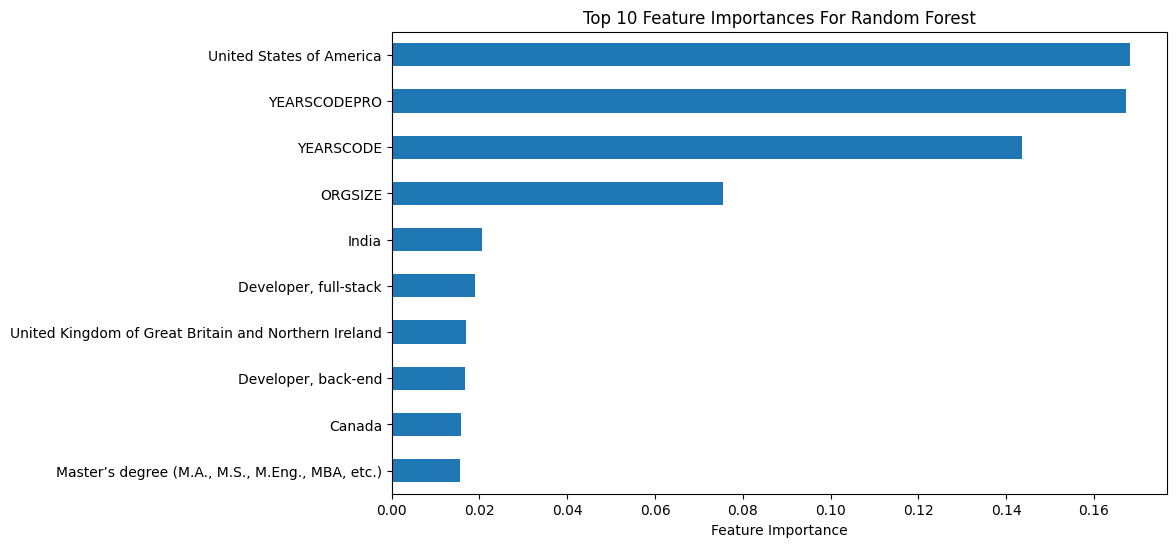

In [47]:
# Get feature importances
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train_c.columns)

# Sort importances
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
feature_importances_sorted.head(10).plot(kind='barh') 
plt.gca().invert_yaxis() 
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances For Random Forest')
plt.show()

In [ ]:
# Predict on the test set
Y_pred_log = best_rf.predict(X_test_c)
Y_pred_c = np.expm1(Y_pred_log)

# Evaluate
mae = mean_absolute_error(Y_test_c, Y_pred_c)
r2 = r2_score(Y_test_c, Y_pred_c)

print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set R²: {r2:.4f}")

Test Set MAE: 24864.2994
Test Set R²: 0.5423


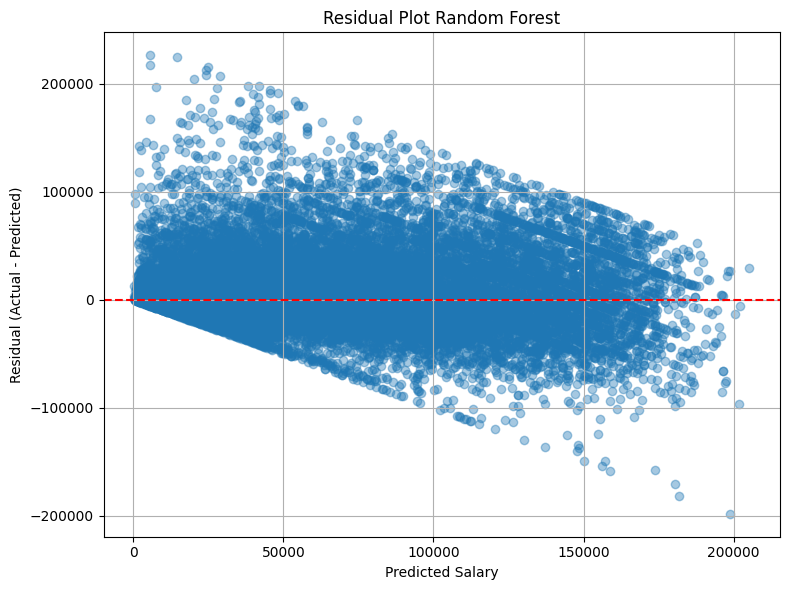

In [14]:
residuals = Y_test_c - Y_pred_c

plt.figure(figsize=(8, 6))
plt.scatter(Y_pred_c, residuals, alpha=0.4)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Salary")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot Random Forest")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Log-transform the target variable
Y_train_log = np.log1p(Y_train_c)

# Create the model
lr = LinearRegression()

# Cross-validate using negative MAE
cv_scores = cross_val_score(lr, X_train_c, Y_train_log, cv=3, scoring='neg_mean_absolute_error')
print("CV MAE scores (neg):", cv_scores)
print("Average MAE:", -np.mean(cv_scores))

# Fit the model
lr.fit(X_train_c, Y_train_log)

# Predict and reverse log
Y_pred_log = lr.predict(X_test_c)
Y_pred_c = np.expm1(Y_pred_log)

# Evaluate
print("MAE:", mean_absolute_error(Y_test_c, Y_pred_c))
print("R^2:", r2_score(Y_test_c, Y_pred_c))

CV MAE scores (neg): [-0.51145073 -0.5128487  -0.5001839 ]
Average MAE: 0.5081611101301505
MAE: 26385.336195754608
R^2: 0.46308809378718574


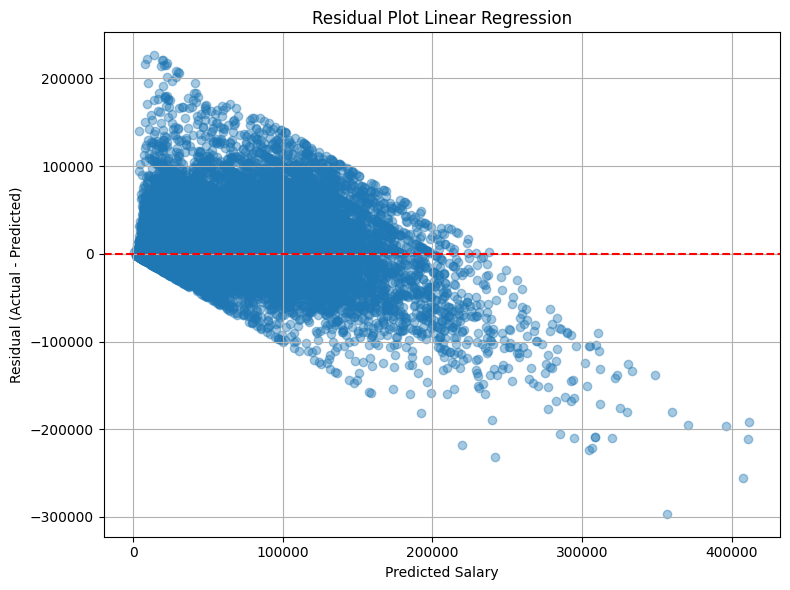

In [16]:
residuals = Y_test_c - Y_pred_c

plt.figure(figsize=(8, 6))
plt.scatter(Y_pred_c, residuals, alpha=0.4)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Salary")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot Linear Regression")
plt.grid(True)
plt.tight_layout()
plt.show()


-------------------------------------------------------------------------------------                       

.

**Job Satisfaction Data Exploration**

.

-------------------------------------------------------------------------------------

**Cleaning**

In [17]:
#get all columns
all_c_jobsat_df = odf_2024.copy()

#drop currency, totalcomp, AITOOL, AINEXT, TBRANCH, SURVERYLENGTH, SURVEYEASE, RESPONSEID
jobsat_onehot = [
   'MAINBRANCH', 'REMOTEWORK', 'DEVTYPE', 'COUNTRY']

jobsat_multilabel = [
    'EMPLOYMENT', 'CODINGACTIVITIES', 'LEARNCODE', 'LEARNCODEONLINE', 'TECHDOC', 'BUYNEWTOOL',
    'TECHENDORSE', 'NEWSOSITES', 'SOHOW', 'AIBEN', 'AIETHICS', 'AICHALLENGES', 'FRUSTRATION', 'PROFESSIONALTECH']

jobsat_include_columns = [
    'AGE', 'YEARSCODE', 'YEARSCODEPRO', 'WORKEXP', 'EDLEVEL', 'ORGSIZE', 
    'PURCHASEINFLUENCE', 'BUILDVSBUY', 'SOVISITFREQ', 'SOACCOUNT', 'SOPARTFREQ', 'SOCOMM',
    'AISELECT', 'AISENT', 'AIACC', 'AICOMPLEX', 'AITHREAT', 'ICORPM', 'TIMESEARCHING', "TIMEANSWERING",
    'PROFESSIONALCLOUD', 'JOBSAT', 'JOBSATPOINTS_1', 'JOBSATPOINTS_4', 'JOBSATPOINTS_5', 'JOBSATPOINTS_6', 
    'JOBSATPOINTS_7',  'JOBSATPOINTS_8',  'JOBSATPOINTS_9', 'JOBSATPOINTS_10', 'JOBSATPOINTS_11', 'KNOWLEDGE_1', 
    'KNOWLEDGE_2', 'KNOWLEDGE_3', 'KNOWLEDGE_4', 'KNOWLEDGE_5', 'KNOWLEDGE_6', 'KNOWLEDGE_7', 'KNOWLEDGE_8', 
    'KNOWLEDGE_9', 'FREQUENCY_1', 'FREQUENCY_2', 'FREQUENCY_3']

#create jobsat
useable_columns = jobsat_multilabel + jobsat_onehot + jobsat_include_columns
jobsat_df = odf_2024[useable_columns]

#drop all NaN

print(f'Shape before drop: {jobsat_df.shape}')
jobsat_df = jobsat_df.dropna()
jobsat_df.reset_index(drop=True, inplace=True)
print(f'Shape before drop: {jobsat_df.shape}')

Shape before drop: (65437, 61)
Shape before drop: (7572, 61)


**Pre-processing**

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

#apply ordinal encoding
ordinal_maps = {
    "AGE" : {
        "Under 18 years old": 0, "18-24 years old": 1, "25-34 years old": 2,
        "35-44 years old": 3, "45-54 years old": 4, "55-64 years old": 5,
        "65 years or older": 6, "Prefer not to say": -1},
    "EDLEVEL": {
        "Primary/elementary school": 0, "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": 1,
        "Some college/university study without earning a degree": 2, "Associate degree (A.A., A.S., etc.)": 3,
        "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": 4, "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": 5,
        "Professional degree (JD, MD, Ph.D, Ed.D, etc.)": 6, "Something else": 7},
    "ORGSIZE": {
        "Just me - I am a freelancer, sole proprietor, etc.": 0, "2 to 9 employees": 1,
        "10 to 19 employees": 2, "20 to 99 employees": 3, "100 to 499 employees": 4,
        "500 to 999 employees": 5, "1,000 to 4,999 employees": 6, "5,000 to 9,999 employees": 7,
        "10,000 or more employees": 8, "I don’t know": -1},
    "PURCHASEINFLUENCE": {
        "I have little or no influence": 0, "I have some influence": 1, 
        "I have a great deal of influence": 2},
    "BUILDVSBUY": {
        "Out-of-the-box is ready to go with little need for customization": 0,
        "Is ready-to-go but also customizable for growth and targeted use cases": 1,
        "Is set up to be customized and needs to be engineered into a usable product": 2},
    "SOVISITFREQ": {
        "Less than once per month or monthly": 0, "A few times per month or weekly": 1,
        "A few times per week": 2, "Daily or almost daily": 3, "Multiple times per day": 4},
    "SOPARTFREQ": {
        "I have never participated in Q&A on Stack Overflow": 0, "Less than once per month or monthly": 1,
        "A few times per month or weekly": 2, "A few times per week": 3, "Daily or almost daily": 4,
        "Multiple times per day": 5},
    "SOCOMM": {
        "No, not at all": 0, "No, not really": 1, "Neutral": 2,
        "Yes, somewhat": 3, "Yes, definitely": 4, "Not sure": 5},
    "SOACCOUNT": {
        "Yes": 1, "No": 0},
    "AISENT": {
        "Very unfavorable": 0, "Unfavorable": 1, "Indifferent": 2,
        "Favorable": 3, "Very favorable": 4, "Unsure": 5},
    "AIACC": {
        "Highly distrust": 0, "Somewhat distrust": 1, "Neither trust nor distrust": 2,
        "Somewhat trust": 3, "Highly trust": 4},
    "AISELECT" : {
        "Yes": 1, "No": 0},
    "AICOMPLEX": {
        "Very poor at handling complex tasks": 0, "Bad at handling complex tasks": 1,
        "Neither good or bad at handling complex tasks": 2, "Good, but not great at handling complex tasks": 3,
        "Very well at handling complex tasks": 4},
    "AITHREAT": {
        "No": 0, "I'm not sure": 1, "Yes": 2},
    "ICORPM": {
        "Individual contributor": 0, "People manager": 1},
    "TIMESEARCHING": {
        "Less than 15 minutes a day": 0, "15-30 minutes a day": 1,
        "30-60 minutes a day": 2, "60-120 minutes a day": 3, "Over 120 minutes a day": 4},
    "TIMEANSWERING": {
        "Less than 15 minutes a day": 0, "15-30 minutes a day": 1, "30-60 minutes a day": 2,
        "60-120 minutes a day": 3, "Over 120 minutes a day": 4},
    "PROFESSIONALCLOUD": {
        "On-prem": 0, "Hybrid (on-prem and cloud)": 1, "Cloud only (single or multi-cloud)": 2}
}
for col, mapping in ordinal_maps.items():
    if col in jobsat_df.columns:
        jobsat_df[col] = jobsat_df[col].map(mapping).astype(int)

knowledge_order = {
    'Strongly agree': 4, 
    'Agree': 3,
    'Neither agree nor disagree': 2,
    'Disagree': 1,
    'Strongly disagree': 0
}
for i in range(1, 10): 
    jobsat_df['KNOWLEDGE_'+str(i)] = jobsat_df['KNOWLEDGE_'+str(i)].map(knowledge_order)

frequency_order = {
    'Never': 0, 
    '1-2 times a week': 1,
    '3-5 times a week': 2, 
    '6-10 times a week': 3, 
    '10+ times a week': 4
}
for i in range(1,4): 
    jobsat_df['FREQUENCY_'+str(i)] = jobsat_df['FREQUENCY_'+str(i)].map(frequency_order)


#encode onehot cols
jobsat_df = pd.get_dummies(jobsat_df, columns=jobsat_onehot, drop_first=True)

#encode multilabel cols
for col in jobsat_multilabel:
    #split cols
    split_col = jobsat_df[col].str.split(';')

    #multilabel instance
    mlb = MultiLabelBinarizer()
    multilabel_encoded = pd.DataFrame(
        mlb.fit_transform(split_col),
        columns=[f"{col}_{cls}" for cls in mlb.classes_],
        index=jobsat_df.index
    )

    #add col to jobsat
    jobsat_df = pd.concat([jobsat_df.drop(columns=col), multilabel_encoded], axis=1)

#convert YEARSCODE to int
jobsat_df['YEARSCODE'] = jobsat_df['YEARSCODE'].replace({
    'More than 50 years': '50',
    'Less than 1 year': '1'
})
jobsat_df['YEARSCODE'] = jobsat_df['YEARSCODE'].astype(int)

#convert YEARSCODEPRO to int
jobsat_df['YEARSCODEPRO'] = jobsat_df['YEARSCODEPRO'].replace({
    'More than 50 years': '50',
    'Less than 1 year': '1'
})
jobsat_df['YEARSCODEPRO'] = jobsat_df['YEARSCODEPRO'].astype(int)

#convert everything else to int
jobsat_df = jobsat_df.astype(int)

#check all columns are ints
all_ints = True
for c in jobsat_df.columns:
    if jobsat_df[c].dtype != np.int64:
        all_ints = False
        break

if all_ints: print('All columns successfully converted to type int\n')
else: print('Error: One or more columns not of type int\n')

print(f'Shape after encoding: {jobsat_df.shape}\n')

All columns successfully converted to type int

Shape after encoding: (7572, 340)



In [19]:
jobsat_df.head(3)

,AGE,YEARSCODE,YEARSCODEPRO,WORKEXP,EDLEVEL,ORGSIZE,PURCHASEINFLUENCE,BUILDVSBUY,SOVISITFREQ,SOACCOUNT,SOPARTFREQ,SOCOMM,AISELECT,AISENT,AIACC,AICOMPLEX,AITHREAT,ICORPM,TIMESEARCHING,TIMEANSWERING,PROFESSIONALCLOUD,JOBSAT,JOBSATPOINTS_1,JOBSATPOINTS_4,JOBSATPOINTS_5,JOBSATPOINTS_6,JOBSATPOINTS_7,JOBSATPOINTS_8,JOBSATPOINTS_9,JOBSATPOINTS_10,JOBSATPOINTS_11,KNOWLEDGE_1,KNOWLEDGE_2,KNOWLEDGE_3,KNOWLEDGE_4,KNOWLEDGE_5,KNOWLEDGE_6,KNOWLEDGE_7,KNOWLEDGE_8,KNOWLEDGE_9,FREQUENCY_1,FREQUENCY_2,FREQUENCY_3,"MAINBRANCH_I am not primarily a developer, but I write code sometimes as part of my work/studies",REMOTEWORK_In-person,REMOTEWORK_Remote,DEVTYPE_Blockchain,DEVTYPE_Cloud infrastructure engineer,DEVTYPE_Data engineer,DEVTYPE_Data or business analyst,DEVTYPE_Data scientist or machine learning specialist,DEVTYPE_Database administrator,DEVTYPE_Designer,DEVTYPE_DevOps specialist,DEVTYPE_Developer Advocate,DEVTYPE_Developer Experience,"DEVTYPE_Developer, AI","DEVTYPE_Developer, QA or test","DEVTYPE_Developer, back-end","DEVTYPE_Developer, desktop or enterprise applications","DEVTYPE_Developer, embedded applications or devices","DEVTYPE_Developer, front-end","DEVTYPE_Developer, full-stack","DEVTYPE_Developer, game or graphics","DEVTYPE_Developer, mobile",DEVTYPE_Educator,"DEVTYPE_Engineer, site reliability",DEVTYPE_Engineering manager,DEVTYPE_Hardware Engineer,DEVTYPE_Marketing or sales professional,DEVTYPE_Other (please specify):,DEVTYPE_Product manager,DEVTYPE_Project manager,DEVTYPE_Research & Development role,DEVTYPE_Scientist,DEVTYPE_Security professional,"DEVTYPE_Senior Executive (C-Suite, VP, etc.)",DEVTYPE_Student,DEVTYPE_System administrator,COUNTRY_Algeria,COUNTRY_Andorra,COUNTRY_Angola,COUNTRY_Argentina,COUNTRY_Armenia,COUNTRY_Australia,COUNTRY_Austria,COUNTRY_Azerbaijan,COUNTRY_Bahrain,COUNTRY_Bangladesh,COUNTRY_Barbados,COUNTRY_Belarus,COUNTRY_Belgium,COUNTRY_Benin,COUNTRY_Bhutan,COUNTRY_Bolivia,COUNTRY_Bosnia and Herzegovina,COUNTRY_Brazil,COUNTRY_Bulgaria,COUNTRY_Burkina Faso,COUNTRY_Cambodia,COUNTRY_Cameroon,COUNTRY_Canada,COUNTRY_Chile,COUNTRY_China,COUNTRY_Colombia,COUNTRY_Costa Rica,COUNTRY_Croatia,COUNTRY_Cuba,COUNTRY_Cyprus,COUNTRY_Czech Republic,COUNTRY_Côte d'Ivoire,COUNTRY_Democratic People's Republic of Korea,COUNTRY_Denmark,COUNTRY_Dominican Republic,COUNTRY_Ecuador,COUNTRY_Egypt,COUNTRY_El Salvador,COUNTRY_Estonia,COUNTRY_Ethiopia,COUNTRY_Finland,COUNTRY_France,COUNTRY_Georgia,COUNTRY_Germany,COUNTRY_Ghana,COUNTRY_Greece,COUNTRY_Guatemala,COUNTRY_Honduras,COUNTRY_Hong Kong (S.A.R.),COUNTRY_Hungary,COUNTRY_Iceland,COUNTRY_India,COUNTRY_Indonesia,"COUNTRY_Iran, Islamic Republic of...",COUNTRY_Iraq,COUNTRY_Ireland,COUNTRY_Isle of Man,COUNTRY_Israel,COUNTRY_Italy,COUNTRY_Jamaica,COUNTRY_Japan,COUNTRY_Jordan,COUNTRY_Kazakhstan,COUNTRY_Kenya,COUNTRY_Kosovo,COUNTRY_Kuwait,COUNTRY_Kyrgyzstan,COUNTRY_Lao People's Democratic Republic,COUNTRY_Latvia,COUNTRY_Lebanon,COUNTRY_Liechtenstein,COUNTRY_Lithuania,COUNTRY_Luxembourg,COUNTRY_Madagascar,COUNTRY_Malawi,COUNTRY_Malaysia,COUNTRY_Maldives,COUNTRY_Malta,COUNTRY_Mexico,COUNTRY_Mongolia,COUNTRY_Montenegro,COUNTRY_Morocco,COUNTRY_Myanmar,COUNTRY_Namibia,COUNTRY_Nepal,COUNTRY_Netherlands,COUNTRY_New Zealand,COUNTRY_Nicaragua,COUNTRY_Nigeria,COUNTRY_Nomadic,COUNTRY_Norway,COUNTRY_Oman,COUNTRY_Pakistan,COUNTRY_Palestine,COUNTRY_Panama,COUNTRY_Paraguay,COUNTRY_Peru,COUNTRY_Philippines,COUNTRY_Poland,COUNTRY_Portugal,COUNTRY_Qatar,COUNTRY_Republic of Korea,COUNTRY_Republic of Moldova,COUNTRY_Republic of North Macedonia,COUNTRY_Romania,COUNTRY_Russian Federation,COUNTRY_Rwanda,COUNTRY_San Marino,COUNTRY_Saudi Arabia,COUNTRY_Senegal,COUNTRY_Serbia,COUNTRY_Singapore,COUNTRY_Slovakia,COUNTRY_Slovenia,COUNTRY_South Africa,COUNTRY_South Korea,COUNTRY_Spain,COUNTRY_Sri Lanka,COUNTRY_Sweden,COUNTRY_Switzerland,COUNTRY_Syrian Arab Republic,COUNTRY_Taiwan,COUNTRY_Tajikistan,COUNTRY_Thailand,COUNTRY_Trinidad and Tobago,COUNTRY_Tunisia,COUNTRY_Turkey,COUNTRY_Turkmenistan,COUNTRY_Uganda,COUNTRY

In [20]:
#reclass JOBSAT to low satisfaction, medium satisfaction, and high satisfaction
def bin_jobsat(val):
    if val <= 4:
        return 0  #low satisfaction
    elif val <= 7:
        return 1  #medium
    else:
        return 2  #high

jobsat_df["JOBSAT_BINNED"] = jobsat_df["JOBSAT"].apply(bin_jobsat)
jobsat_df.drop(columns="JOBSAT", inplace=True)

**Model Implementation**

In [88]:
#Data preparation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

X = jobsat_df.drop(columns=["JOBSAT_BINNED"])
y = jobsat_df["JOBSAT_BINNED"]

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#select the top 20 features combination
selector = SelectKBest(score_func=mutual_info_classif, k=75)
X_selected = selector.fit_transform(X, y)

#get the names of the selected features
selected_features = X.columns[selector.get_support()]
jobsat_df['JOBSAT_BINNED'].value_counts()

JOBSAT_BINNED
2    3650
1    3071
0     851
Name: count, dtype: int64

In [89]:
from sklearn.model_selection import train_test_split

#reassign X with seelcted features
X = jobsat_df[selected_features]

#split data into train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn.feature_selection import f_classif

def run_fp_growth(X, y_binned, min_support_vals=[0.01, 0.03, 0.05]):

    all_rules = []
    for label in sorted(y_binned.unique()):
        # Subset data
        X_bin = X[y_binned == label]

        # Only keep true (1) values in transactions
        transactions = X_bin.apply(
            lambda row: [f"{col}={row[col]}" for col in X_bin.columns if row[col] == 1],
            axis=1
        ).tolist()

        # One-hot encode
        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        df_trans = pd.DataFrame(te_ary, columns=te.columns_)

        for sup in min_support_vals:
            fi = fpgrowth(df_trans, min_support=sup, use_colnames=True)
            if fi.empty or fi['itemsets'].apply(len).max() < 2:
                continue

            rules = association_rules(fi, metric="lift", min_threshold=0.7)
            if rules.empty:
                continue

            for _, r in rules.iterrows():
                all_rules.append({
                    'bin': label,
                    'support': r['support'],
                    'confidence': r['confidence'],
                    'lift': r['lift'],
                    'antecedents': ', '.join(sorted(r['antecedents'])),
                    'consequents': ', '.join(sorted(r['consequents'])),
                    'min_support': sup,
                })

    if all_rules:
        rules_df = pd.DataFrame(all_rules)
        rules_df = rules_df.sort_values(['bin', 'lift'], ascending=[True, False])
        print("\n=== Association Rules Summary ===")
        print(rules_df.to_string(index=False))
        return rules_df
    else:
        print("No association rules found for the given parameters.")
        return pd.DataFrame()

fp_results = run_fp_growth(X_train, y_train, [0.1, 0.3, 0.5])

In [ ]:
# Assumes fp_results is a DataFrame with columns: 'bin', 'min_support', 'support', 'confidence', 'lift', etc.

for support_val in sorted(fp_results['min_support'].unique()):
    subset = fp_results[fp_results['min_support'] == support_val]
    
    avg_support = subset['support'].mean()
    avg_confidence = subset['confidence'].mean()
    avg_lift = subset['lift'].mean()

    print(f"\nMetrics for min_support = {support_val}")
    print(f"Average Support:    {avg_support:.4f}")
    print(f"Average Confidence: {avg_confidence:.4f}")
    print(f"Average Lift:       {avg_lift:.4f}")
    print(f"Rule Count:         {len(subset)}")



Metrics for min_support = 0.1
Average Support:    0.1485
Average Confidence: 0.4053
Average Lift:       1.0410
Rule Count:         214

Metrics for min_support = 0.3
Average Support:    0.3070
Average Confidence: 0.5524
Average Lift:       0.9934
Rule Count:         4


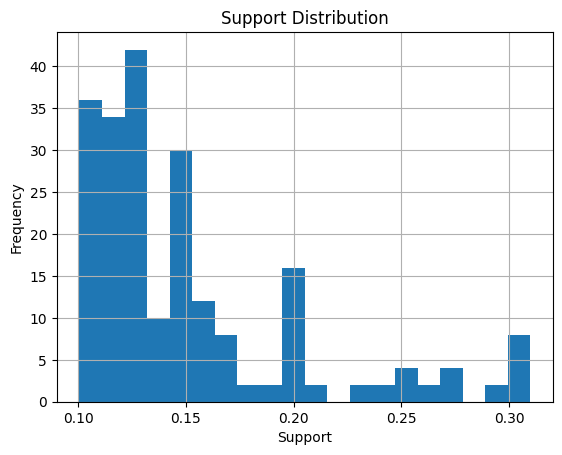

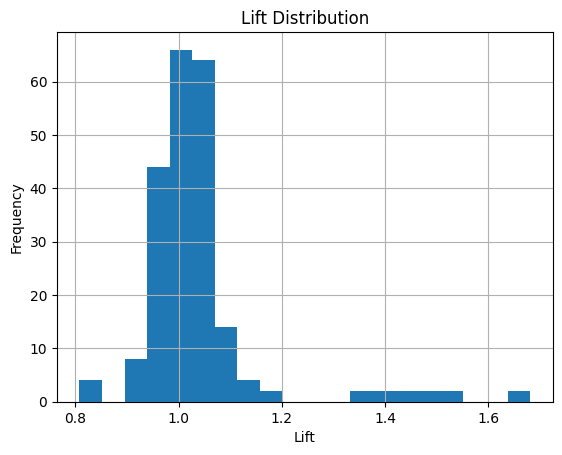

In [ ]:
import matplotlib.pyplot as plt

fp_results['support'].hist(bins=20)
plt.title("Support Distribution")
plt.xlabel("Support")
plt.ylabel("Frequency")
plt.show()

fp_results['lift'].hist(bins=20)
plt.title("Lift Distribution")
plt.xlabel("Lift")
plt.ylabel("Frequency")
plt.show()


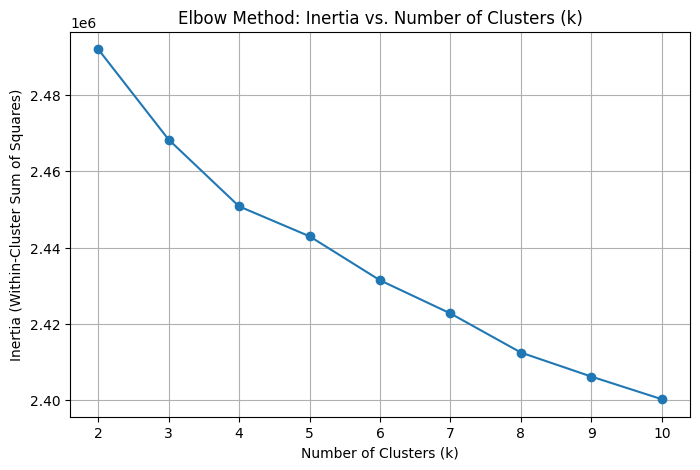

In [ ]:
inertias = []
K_values = range(2, 11) 

for k in K_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_values, inertias, marker='o')
plt.title("Elbow Method: Inertia vs. Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()


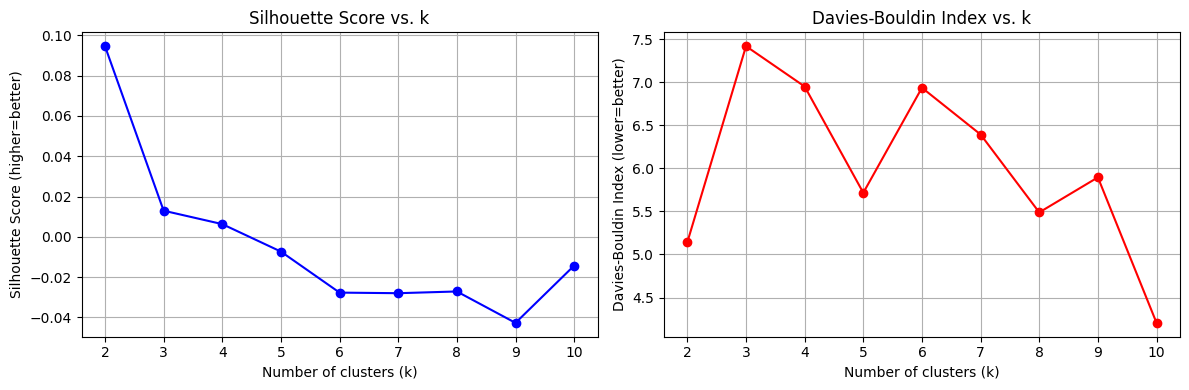

In [ ]:
silhouette_scores = []
db_scores = []

for k in K_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, cluster_labels)
    db_score = davies_bouldin_score(X_scaled, cluster_labels)
    
    silhouette_scores.append(sil_score)
    db_scores.append(db_score)

# Plot Silhouette Scores
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(K_values, silhouette_scores, marker='o', color='blue', label='Silhouette')
plt.title("Silhouette Score vs. k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score (higher=better)")
plt.grid(True)

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(K_values, db_scores, marker='o', color='red', label='Davies-Bouldin')
plt.title("Davies-Bouldin Index vs. k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies-Bouldin Index (lower=better)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Run k-means model
final_k = 2
kmeans_final = KMeans(n_clusters=final_k, n_init=10)
final_labels = kmeans_final.fit_predict(X_scaled)

# Evaluate final model
final_sil_score = silhouette_score(X_scaled, final_labels)
final_db_score = davies_bouldin_score(X_scaled, final_labels)

# Show results
print(f"Final K-Means results (k={final_k}):")
print(f"Silhouette Score  = {final_sil_score:.3f} (higher is better)")
print(f"Davies-Bouldin    = {final_db_score:.3f} (lower is better)")


Final K-Means results (k=2):
Silhouette Score  = 0.095 (higher is better)
Davies-Bouldin    = 5.141 (lower is better)


In [ ]:
# Create jobsat_clusters
jobsat_clusters = jobsat_df.copy()
jobsat_clusters["Cluster"] = final_labels

cluster_counts = jobsat_clusters["Cluster"].value_counts().sort_index()
print("Number of rows in each cluster:")
print(cluster_counts)
jobsat_clusters.head(5)


Number of rows in each cluster:
Cluster
0    1105
1    6467
Name: count, dtype: int64


,AGE,YEARSCODE,YEARSCODEPRO,WORKEXP,EDLEVEL,ORGSIZE,PURCHASEINFLUENCE,BUILDVSBUY,SOVISITFREQ,SOACCOUNT,SOPARTFREQ,SOCOMM,AISELECT,AISENT,AIACC,AICOMPLEX,AITHREAT,ICORPM,TIMESEARCHING,TIMEANSWERING,PROFESSIONALCLOUD,JOBSATPOINTS_1,JOBSATPOINTS_4,JOBSATPOINTS_5,JOBSATPOINTS_6,JOBSATPOINTS_7,JOBSATPOINTS_8,JOBSATPOINTS_9,JOBSATPOINTS_10,JOBSATPOINTS_11,KNOWLEDGE_1,KNOWLEDGE_2,KNOWLEDGE_3,KNOWLEDGE_4,KNOWLEDGE_5,KNOWLEDGE_6,KNOWLEDGE_7,KNOWLEDGE_8,KNOWLEDGE_9,FREQUENCY_1,FREQUENCY_2,FREQUENCY_3,"MAINBRANCH_I am not primarily a developer, but I write code sometimes as part of my work/studies",REMOTEWORK_In-person,REMOTEWORK_Remote,DEVTYPE_Blockchain,DEVTYPE_Cloud infrastructure engineer,DEVTYPE_Data engineer,DEVTYPE_Data or business analyst,DEVTYPE_Data scientist or machine learning specialist,DEVTYPE_Database administrator,DEVTYPE_Designer,DEVTYPE_DevOps specialist,DEVTYPE_Developer Advocate,DEVTYPE_Developer Experience,"DEVTYPE_Developer, AI","DEVTYPE_Developer, QA or test","DEVTYPE_Developer, back-end","DEVTYPE_Developer, desktop or enterprise applications","DEVTYPE_Developer, embedded applications or devices","DEVTYPE_Developer, front-end","DEVTYPE_Developer, full-stack","DEVTYPE_Developer, game or graphics","DEVTYPE_Developer, mobile",DEVTYPE_Educator,"DEVTYPE_Engineer, site reliability",DEVTYPE_Engineering manager,DEVTYPE_Hardware Engineer,DEVTYPE_Marketing or sales professional,DEVTYPE_Other (please specify):,DEVTYPE_Product manager,DEVTYPE_Project manager,DEVTYPE_Research & Development role,DEVTYPE_Scientist,DEVTYPE_Security professional,"DEVTYPE_Senior Executive (C-Suite, VP, etc.)",DEVTYPE_Student,DEVTYPE_System administrator,COUNTRY_Algeria,COUNTRY_Andorra,COUNTRY_Angola,COUNTRY_Argentina,COUNTRY_Armenia,COUNTRY_Australia,COUNTRY_Austria,COUNTRY_Azerbaijan,COUNTRY_Bahrain,COUNTRY_Bangladesh,COUNTRY_Barbados,COUNTRY_Belarus,COUNTRY_Belgium,COUNTRY_Benin,COUNTRY_Bhutan,COUNTRY_Bolivia,COUNTRY_Bosnia and Herzegovina,COUNTRY_Brazil,COUNTRY_Bulgaria,COUNTRY_Burkina Faso,COUNTRY_Cambodia,COUNTRY_Cameroon,COUNTRY_Canada,COUNTRY_Chile,COUNTRY_China,COUNTRY_Colombia,COUNTRY_Costa Rica,COUNTRY_Croatia,COUNTRY_Cuba,COUNTRY_Cyprus,COUNTRY_Czech Republic,COUNTRY_Côte d'Ivoire,COUNTRY_Democratic People's Republic of Korea,COUNTRY_Denmark,COUNTRY_Dominican Republic,COUNTRY_Ecuador,COUNTRY_Egypt,COUNTRY_El Salvador,COUNTRY_Estonia,COUNTRY_Ethiopia,COUNTRY_Finland,COUNTRY_France,COUNTRY_Georgia,COUNTRY_Germany,COUNTRY_Ghana,COUNTRY_Greece,COUNTRY_Guatemala,COUNTRY_Honduras,COUNTRY_Hong Kong (S.A.R.),COUNTRY_Hungary,COUNTRY_Iceland,COUNTRY_India,COUNTRY_Indonesia,"COUNTRY_Iran, Islamic Republic of...",COUNTRY_Iraq,COUNTRY_Ireland,COUNTRY_Isle of Man,COUNTRY_Israel,COUNTRY_Italy,COUNTRY_Jamaica,COUNTRY_Japan,COUNTRY_Jordan,COUNTRY_Kazakhstan,COUNTRY_Kenya,COUNTRY_Kosovo,COUNTRY_Kuwait,COUNTRY_Kyrgyzstan,COUNTRY_Lao People's Democratic Republic,COUNTRY_Latvia,COUNTRY_Lebanon,COUNTRY_Liechtenstein,COUNTRY_Lithuania,COUNTRY_Luxembourg,COUNTRY_Madagascar,COUNTRY_Malawi,COUNTRY_Malaysia,COUNTRY_Maldives,COUNTRY_Malta,COUNTRY_Mexico,COUNTRY_Mongolia,COUNTRY_Montenegro,COUNTRY_Morocco,COUNTRY_Myanmar,COUNTRY_Namibia,COUNTRY_Nepal,COUNTRY_Netherlands,COUNTRY_New Zealand,COUNTRY_Nicaragua,COUNTRY_Nigeria,COUNTRY_Nomadic,COUNTRY_Norway,COUNTRY_Oman,COUNTRY_Pakistan,COUNTRY_Palestine,COUNTRY_Panama,COUNTRY_Paraguay,COUNTRY_Peru,COUNTRY_Philippines,COUNTRY_Poland,COUNTRY_Portugal,COUNTRY_Qatar,COUNTRY_Republic of Korea,COUNTRY_Republic of Moldova,COUNTRY_Republic of North Macedonia,COUNTRY_Romania,COUNTRY_Russian Federation,COUNTRY_Rwanda,COUNTRY_San Marino,COUNTRY_Saudi Arabia,COUNTRY_Senegal,COUNTRY_Serbia,COUNTRY_Singapore,COUNTRY_Slovakia,COUNTRY_Slovenia,COUNTRY_South Africa,COUNTRY_South Korea,COUNTRY_Spain,COUNTRY_Sri Lanka,COUNTRY_Sweden,COUNTRY_Switzerland,COUNTRY_Syrian Arab Republic,COUNTRY_Taiwan,COUNTRY_Tajikistan,COUNTRY_Thailand,COUNTRY_Trinidad and Tobago,COUNTRY_Tunisia,COUNTRY_Turkey,COUNTRY_Turkmenistan,COUNTRY_Uganda,COUNTRY_Ukrain

In [ ]:
# Group by 'Cluster' and compute means of all features
cluster_summary = jobsat_clusters.groupby("Cluster").mean()

print("Average feature values per cluster:")
display(cluster_summary.head())

cluster_summary_median = jobsat_clusters.groupby("Cluster").median()
print("Median feature values per cluster:")
display(cluster_summary_median.head())



Average feature values per cluster:


,AGE,YEARSCODE,YEARSCODEPRO,WORKEXP,EDLEVEL,ORGSIZE,PURCHASEINFLUENCE,BUILDVSBUY,SOVISITFREQ,SOACCOUNT,SOPARTFREQ,SOCOMM,AISELECT,AISENT,AIACC,AICOMPLEX,AITHREAT,ICORPM,TIMESEARCHING,TIMEANSWERING,PROFESSIONALCLOUD,JOBSATPOINTS_1,JOBSATPOINTS_4,JOBSATPOINTS_5,JOBSATPOINTS_6,JOBSATPOINTS_7,JOBSATPOINTS_8,JOBSATPOINTS_9,JOBSATPOINTS_10,JOBSATPOINTS_11,KNOWLEDGE_1,KNOWLEDGE_2,KNOWLEDGE_3,KNOWLEDGE_4,KNOWLEDGE_5,KNOWLEDGE_6,KNOWLEDGE_7,KNOWLEDGE_8,KNOWLEDGE_9,FREQUENCY_1,FREQUENCY_2,FREQUENCY_3,"MAINBRANCH_I am not primarily a developer, but I write code sometimes as part of my work/studies",REMOTEWORK_In-person,REMOTEWORK_Remote,DEVTYPE_Blockchain,DEVTYPE_Cloud infrastructure engineer,DEVTYPE_Data engineer,DEVTYPE_Data or business analyst,DEVTYPE_Data scientist or machine learning specialist,DEVTYPE_Database administrator,DEVTYPE_Designer,DEVTYPE_DevOps specialist,DEVTYPE_Developer Advocate,DEVTYPE_Developer Experience,"DEVTYPE_Developer, AI","DEVTYPE_Developer, QA or test","DEVTYPE_Developer, back-end","DEVTYPE_Developer, desktop or enterprise applications","DEVTYPE_Developer, embedded applications or devices","DEVTYPE_Developer, front-end","DEVTYPE_Developer, full-stack","DEVTYPE_Developer, game or graphics","DEVTYPE_Developer, mobile",DEVTYPE_Educator,"DEVTYPE_Engineer, site reliability",DEVTYPE_Engineering manager,DEVTYPE_Hardware Engineer,DEVTYPE_Marketing or sales professional,DEVTYPE_Other (please specify):,DEVTYPE_Product manager,DEVTYPE_Project manager,DEVTYPE_Research & Development role,DEVTYPE_Scientist,DEVTYPE_Security professional,"DEVTYPE_Senior Executive (C-Suite, VP, etc.)",DEVTYPE_Student,DEVTYPE_System administrator,COUNTRY_Algeria,COUNTRY_Andorra,COUNTRY_Angola,COUNTRY_Argentina,COUNTRY_Armenia,COUNTRY_Australia,COUNTRY_Austria,COUNTRY_Azerbaijan,COUNTRY_Bahrain,COUNTRY_Bangladesh,COUNTRY_Barbados,COUNTRY_Belarus,COUNTRY_Belgium,COUNTRY_Benin,COUNTRY_Bhutan,COUNTRY_Bolivia,COUNTRY_Bosnia and Herzegovina,COUNTRY_Brazil,COUNTRY_Bulgaria,COUNTRY_Burkina Faso,COUNTRY_Cambodia,COUNTRY_Cameroon,COUNTRY_Canada,COUNTRY_Chile,COUNTRY_China,COUNTRY_Colombia,COUNTRY_Costa Rica,COUNTRY_Croatia,COUNTRY_Cuba,COUNTRY_Cyprus,COUNTRY_Czech Republic,COUNTRY_Côte d'Ivoire,COUNTRY_Democratic People's Republic of Korea,COUNTRY_Denmark,COUNTRY_Dominican Republic,COUNTRY_Ecuador,COUNTRY_Egypt,COUNTRY_El Salvador,COUNTRY_Estonia,COUNTRY_Ethiopia,COUNTRY_Finland,COUNTRY_France,COUNTRY_Georgia,COUNTRY_Germany,COUNTRY_Ghana,COUNTRY_Greece,COUNTRY_Guatemala,COUNTRY_Honduras,COUNTRY_Hong Kong (S.A.R.),COUNTRY_Hungary,COUNTRY_Iceland,COUNTRY_India,COUNTRY_Indonesia,"COUNTRY_Iran, Islamic Republic of...",COUNTRY_Iraq,COUNTRY_Ireland,COUNTRY_Isle of Man,COUNTRY_Israel,COUNTRY_Italy,COUNTRY_Jamaica,COUNTRY_Japan,COUNTRY_Jordan,COUNTRY_Kazakhstan,COUNTRY_Kenya,COUNTRY_Kosovo,COUNTRY_Kuwait,COUNTRY_Kyrgyzstan,COUNTRY_Lao People's Democratic Republic,COUNTRY_Latvia,COUNTRY_Lebanon,COUNTRY_Liechtenstein,COUNTRY_Lithuania,COUNTRY_Luxembourg,COUNTRY_Madagascar,COUNTRY_Malawi,COUNTRY_Malaysia,COUNTRY_Maldives,COUNTRY_Malta,COUNTRY_Mexico,COUNTRY_Mongolia,COUNTRY_Montenegro,COUNTRY_Morocco,COUNTRY_Myanmar,COUNTRY_Namibia,COUNTRY_Nepal,COUNTRY_Netherlands,COUNTRY_New Zealand,COUNTRY_Nicaragua,COUNTRY_Nigeria,COUNTRY_Nomadic,COUNTRY_Norway,COUNTRY_Oman,COUNTRY_Pakistan,COUNTRY_Palestine,COUNTRY_Panama,COUNTRY_Paraguay,COUNTRY_Peru,COUNTRY_Philippines,COUNTRY_Poland,COUNTRY_Portugal,COUNTRY_Qatar,COUNTRY_Republic of Korea,COUNTRY_Republic of Moldova,COUNTRY_Republic of North Macedonia,COUNTRY_Romania,COUNTRY_Russian Federation,COUNTRY_Rwanda,COUNTRY_San Marino,COUNTRY_Saudi Arabia,COUNTRY_Senegal,COUNTRY_Serbia,COUNTRY_Singapore,COUNTRY_Slovakia,COUNTRY_Slovenia,COUNTRY_South Africa,COUNTRY_South Korea,COUNTRY_Spain,COUNTRY_Sri Lanka,COUNTRY_Sweden,COUNTRY_Switzerland,COUNTRY_Syrian Arab Republic,COUNTRY_Taiwan,COUNTRY_Tajikistan,COUNTRY_Thailand,COUNTRY_Trinidad and Tobago,COUNTRY_Tunisia,COUNTRY_Turkey,COUNTRY_Turkmenistan,COUNTRY_Uganda,COUNTRY_Ukrain

Median feature values per cluster:


,AGE,YEARSCODE,YEARSCODEPRO,WORKEXP,EDLEVEL,ORGSIZE,PURCHASEINFLUENCE,BUILDVSBUY,SOVISITFREQ,SOACCOUNT,SOPARTFREQ,SOCOMM,AISELECT,AISENT,AIACC,AICOMPLEX,AITHREAT,ICORPM,TIMESEARCHING,TIMEANSWERING,PROFESSIONALCLOUD,JOBSATPOINTS_1,JOBSATPOINTS_4,JOBSATPOINTS_5,JOBSATPOINTS_6,JOBSATPOINTS_7,JOBSATPOINTS_8,JOBSATPOINTS_9,JOBSATPOINTS_10,JOBSATPOINTS_11,KNOWLEDGE_1,KNOWLEDGE_2,KNOWLEDGE_3,KNOWLEDGE_4,KNOWLEDGE_5,KNOWLEDGE_6,KNOWLEDGE_7,KNOWLEDGE_8,KNOWLEDGE_9,FREQUENCY_1,FREQUENCY_2,FREQUENCY_3,"MAINBRANCH_I am not primarily a developer, but I write code sometimes as part of my work/studies",REMOTEWORK_In-person,REMOTEWORK_Remote,DEVTYPE_Blockchain,DEVTYPE_Cloud infrastructure engineer,DEVTYPE_Data engineer,DEVTYPE_Data or business analyst,DEVTYPE_Data scientist or machine learning specialist,DEVTYPE_Database administrator,DEVTYPE_Designer,DEVTYPE_DevOps specialist,DEVTYPE_Developer Advocate,DEVTYPE_Developer Experience,"DEVTYPE_Developer, AI","DEVTYPE_Developer, QA or test","DEVTYPE_Developer, back-end","DEVTYPE_Developer, desktop or enterprise applications","DEVTYPE_Developer, embedded applications or devices","DEVTYPE_Developer, front-end","DEVTYPE_Developer, full-stack","DEVTYPE_Developer, game or graphics","DEVTYPE_Developer, mobile",DEVTYPE_Educator,"DEVTYPE_Engineer, site reliability",DEVTYPE_Engineering manager,DEVTYPE_Hardware Engineer,DEVTYPE_Marketing or sales professional,DEVTYPE_Other (please specify):,DEVTYPE_Product manager,DEVTYPE_Project manager,DEVTYPE_Research & Development role,DEVTYPE_Scientist,DEVTYPE_Security professional,"DEVTYPE_Senior Executive (C-Suite, VP, etc.)",DEVTYPE_Student,DEVTYPE_System administrator,COUNTRY_Algeria,COUNTRY_Andorra,COUNTRY_Angola,COUNTRY_Argentina,COUNTRY_Armenia,COUNTRY_Australia,COUNTRY_Austria,COUNTRY_Azerbaijan,COUNTRY_Bahrain,COUNTRY_Bangladesh,COUNTRY_Barbados,COUNTRY_Belarus,COUNTRY_Belgium,COUNTRY_Benin,COUNTRY_Bhutan,COUNTRY_Bolivia,COUNTRY_Bosnia and Herzegovina,COUNTRY_Brazil,COUNTRY_Bulgaria,COUNTRY_Burkina Faso,COUNTRY_Cambodia,COUNTRY_Cameroon,COUNTRY_Canada,COUNTRY_Chile,COUNTRY_China,COUNTRY_Colombia,COUNTRY_Costa Rica,COUNTRY_Croatia,COUNTRY_Cuba,COUNTRY_Cyprus,COUNTRY_Czech Republic,COUNTRY_Côte d'Ivoire,COUNTRY_Democratic People's Republic of Korea,COUNTRY_Denmark,COUNTRY_Dominican Republic,COUNTRY_Ecuador,COUNTRY_Egypt,COUNTRY_El Salvador,COUNTRY_Estonia,COUNTRY_Ethiopia,COUNTRY_Finland,COUNTRY_France,COUNTRY_Georgia,COUNTRY_Germany,COUNTRY_Ghana,COUNTRY_Greece,COUNTRY_Guatemala,COUNTRY_Honduras,COUNTRY_Hong Kong (S.A.R.),COUNTRY_Hungary,COUNTRY_Iceland,COUNTRY_India,COUNTRY_Indonesia,"COUNTRY_Iran, Islamic Republic of...",COUNTRY_Iraq,COUNTRY_Ireland,COUNTRY_Isle of Man,COUNTRY_Israel,COUNTRY_Italy,COUNTRY_Jamaica,COUNTRY_Japan,COUNTRY_Jordan,COUNTRY_Kazakhstan,COUNTRY_Kenya,COUNTRY_Kosovo,COUNTRY_Kuwait,COUNTRY_Kyrgyzstan,COUNTRY_Lao People's Democratic Republic,COUNTRY_Latvia,COUNTRY_Lebanon,COUNTRY_Liechtenstein,COUNTRY_Lithuania,COUNTRY_Luxembourg,COUNTRY_Madagascar,COUNTRY_Malawi,COUNTRY_Malaysia,COUNTRY_Maldives,COUNTRY_Malta,COUNTRY_Mexico,COUNTRY_Mongolia,COUNTRY_Montenegro,COUNTRY_Morocco,COUNTRY_Myanmar,COUNTRY_Namibia,COUNTRY_Nepal,COUNTRY_Netherlands,COUNTRY_New Zealand,COUNTRY_Nicaragua,COUNTRY_Nigeria,COUNTRY_Nomadic,COUNTRY_Norway,COUNTRY_Oman,COUNTRY_Pakistan,COUNTRY_Palestine,COUNTRY_Panama,COUNTRY_Paraguay,COUNTRY_Peru,COUNTRY_Philippines,COUNTRY_Poland,COUNTRY_Portugal,COUNTRY_Qatar,COUNTRY_Republic of Korea,COUNTRY_Republic of Moldova,COUNTRY_Republic of North Macedonia,COUNTRY_Romania,COUNTRY_Russian Federation,COUNTRY_Rwanda,COUNTRY_San Marino,COUNTRY_Saudi Arabia,COUNTRY_Senegal,COUNTRY_Serbia,COUNTRY_Singapore,COUNTRY_Slovakia,COUNTRY_Slovenia,COUNTRY_South Africa,COUNTRY_South Korea,COUNTRY_Spain,COUNTRY_Sri Lanka,COUNTRY_Sweden,COUNTRY_Switzerland,COUNTRY_Syrian Arab Republic,COUNTRY_Taiwan,COUNTRY_Tajikistan,COUNTRY_Thailand,COUNTRY_Trinidad and Tobago,COUNTRY_Tunisia,COUNTRY_Turkey,COUNTRY_Turkmenistan,COUNTRY_Uganda,COUNTRY_Ukrain

In [ ]:
# Calculate the variance across clusters for each feature

variances = cluster_summary.var(axis=0)

# Sort features by descending variance
top_10_features = variances.nlargest(10).index
print("Top 10 features that differ the most across clusters:")
print(top_10_features)

# Look at the mean values of just those top 10
summary_top10 = cluster_summary[top_10_features]
print("\nMean values of top 10 differing features by cluster:")
display(summary_top10)


Top 10 features that differ the most across clusters:
Index(['JOBSATPOINTS_7', 'JOBSATPOINTS_6', 'JOBSATPOINTS_8', 'JOBSATPOINTS_9',
       'JOBSATPOINTS_1', 'JOBSATPOINTS_10', 'JOBSATPOINTS_5',
       'JOBSATPOINTS_11', 'JOBSATPOINTS_4', 'YEARSCODE'],
      dtype='object')

Mean values of top 10 differing features by cluster:


,JOBSATPOINTS_7,JOBSATPOINTS_6,JOBSATPOINTS_8,JOBSATPOINTS_9,JOBSATPOINTS_1,JOBSATPOINTS_10,JOBSATPOINTS_5,JOBSATPOINTS_11,JOBSATPOINTS_4,YEARSCODE
Cluster,,,,,,,,,,
0,79.447964,79.057014,73.853394,69.120362,69.865158,59.432579,55.066968,54.992760,35.361086,10.915837
1,17.856812,18.359208,14.808567,10.569043,13.308025,5.113499,4.395392,4.357353,4.092469,16.219112


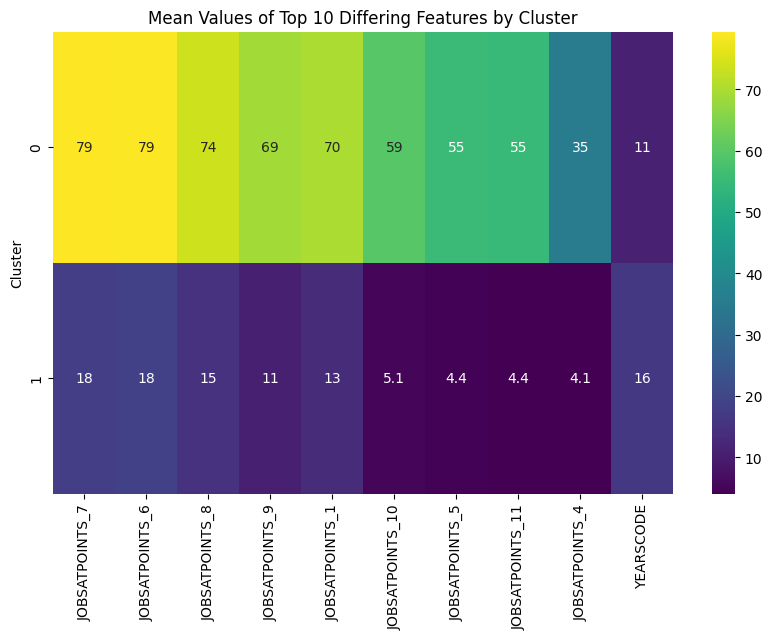

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(summary_top10, annot=True, cmap="viridis")
plt.title("Mean Values of Top 10 Differing Features by Cluster")
plt.ylabel("Cluster")
plt.show()


Cluster vs. Job Satisfaction Bins:
JOBSAT_BINNED    0     1     2
Cluster                       
0               97   441   567
1              754  2630  3083


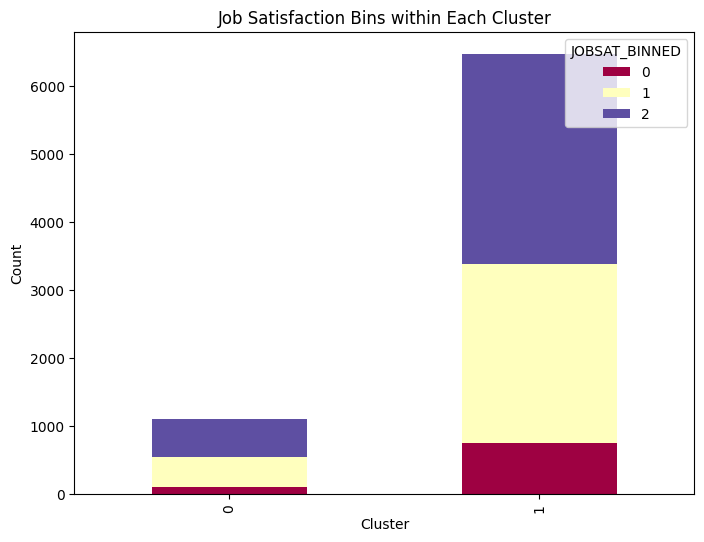

In [ ]:
import pandas as pd

cross_tab = pd.crosstab(jobsat_clusters['Cluster'], jobsat_clusters['JOBSAT_BINNED'])
print("Cluster vs. Job Satisfaction Bins:")
print(cross_tab)

cross_tab.plot(kind='bar', stacked=True, figsize=(8,6), colormap='Spectral')
plt.title("Job Satisfaction Bins within Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="JOBSAT_BINNED", loc="upper right")
plt.show()


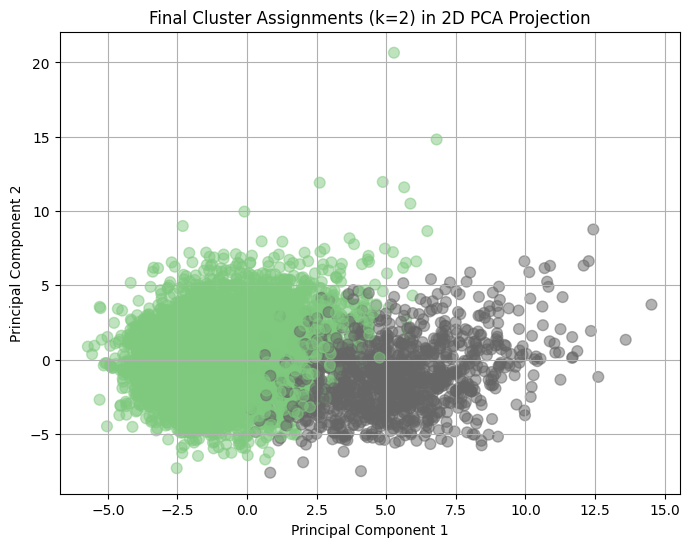

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=final_k, n_init=10)
cluster_labels = kmeans_model.fit_predict(X_scaled)

# PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=cluster_labels, 
    cmap='Accent', 
    s=60, alpha=0.5
)
plt.title(f"Final Cluster Assignments (k={final_k}) in 2D PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
